In [1]:
## Breast Cancer Classification Transfer Learning VGG16
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import sklearn
import tensorflow as tf

from sklearn.utils import class_weight  # Import class_weight
from sklearn.metrics import confusion_matrix, classification_report

2025-05-07 14:41:17.054528: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-07 14:41:17.125490: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-07 14:41:17.143424: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-07 14:41:17.249073: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-07 14:41:18.447685: W tensorflow/compiler/tf2

In [2]:
### Creating Dataset
print(os.listdir('../breast_full_dataset'))

### Train Test Split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_resnet_v2  import preprocess_input as base_preprocess

['Benign', 'Malignant']


In [3]:
image_gen = ImageDataGenerator(
                               #preprocessing_function=base_preprocess,
                               validation_split=0.15)
data_dir = "../breast_full_dataset"
batch_size = 8
target_size = (224,224)

train_image_gen = image_gen.flow_from_directory(data_dir, 
                                          target_size=target_size,
                                          color_mode='rgb',
                                          batch_size=batch_size,
                                          class_mode='categorical',
                                          subset="training")

test_image_gen = image_gen.flow_from_directory(data_dir, 
                                          target_size=target_size, 
                                          color_mode='rgb',
                                          batch_size=batch_size,
                                          class_mode='categorical',
                                          shuffle=False,
                                          subset="validation")

Found 6488 images belonging to 2 classes.
Found 1144 images belonging to 2 classes.


In [3]:
# Here, we add random rotation, zoom, brightness, vertical flip, etc.
image_gen = ImageDataGenerator(
    preprocessing_function=base_preprocess,
    validation_split=0.15,
    rotation_range=20,        # Random rotation in degrees
    #zoom_range=0.1,           # Random zoom
    brightness_range=[1.0, 1.5],  # Brightness adjustment
    vertical_flip=True,       # Flip vertically
)

data_dir = "../breast_full_dataset"
batch_size = 8
target_size = (224, 224)

train_image_gen = image_gen.flow_from_directory(
    data_dir,
    target_size=target_size,
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    subset="training"
)

test_image_gen = image_gen.flow_from_directory(
    data_dir,
    target_size=target_size,
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    subset="validation"
)

Found 6488 images belonging to 2 classes.
Found 1144 images belonging to 2 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.81960785..0.81960785].


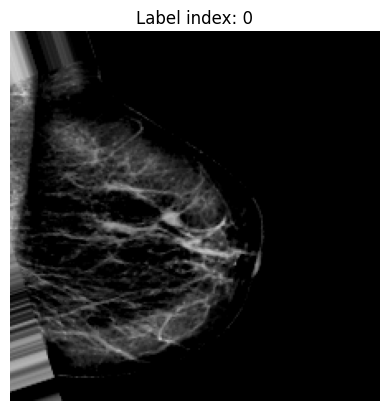

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8509804..0.4666667].


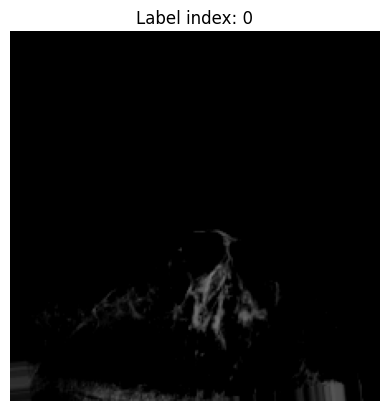

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8117647..0.8117647].


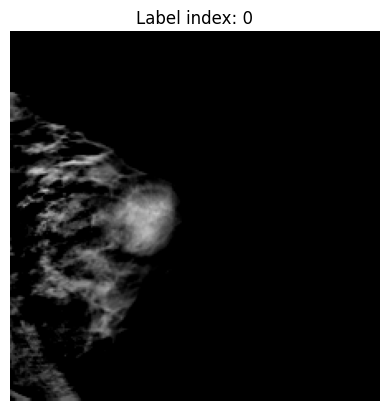

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8117647..1.0].


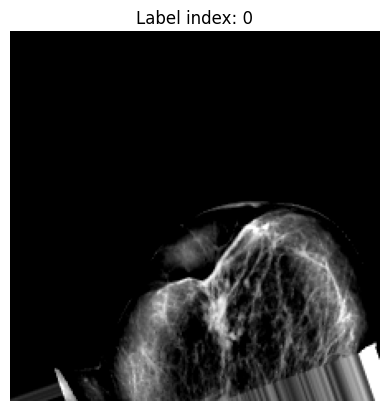

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.81960785..1.0].


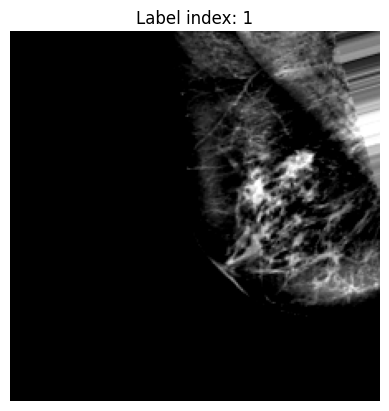

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.85882354].


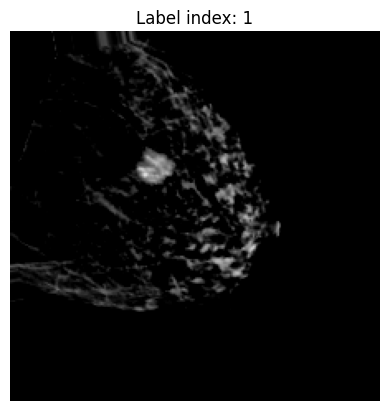

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.79607844..0.7647059].


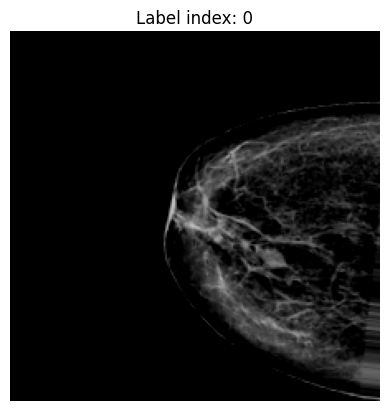

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.84313726..0.9607843].


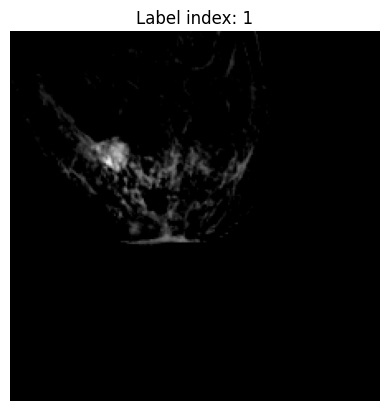

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Fetch a batch of images (and their labels) from the training generator
images, labels = next(train_image_gen)  # images.shape == (batch_size, height, width, channels)

# Display the first 5 images (or as many as you like)
num_to_show = len(images)
for i in range(num_to_show):
    plt.figure()  # Create a new figure for each image
    plt.imshow(images[i])  # Convert floats to uint8 for display (if needed)
    plt.title(f"Label index: {np.argmax(labels[i])}")  # Convert one-hot to class index (if categorical)
    plt.axis('off')
    plt.show()


In [4]:
print(test_image_gen.class_indices)
train_labels = train_image_gen.classes  # Extracts the classes (integer encoded labels)

{'Benign': 0, 'Malignant': 1}


In [5]:
# Get the unique class names and their corresponding indices
class_names = list(train_image_gen.class_indices.keys())
print(f"Class names: {class_names}")

Class names: ['Benign', 'Malignant']


In [6]:
# Compute class weights based on the labels
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(train_labels),
                                                  y=train_labels)

# Create a dictionary mapping class indices to weights
class_wt_dict = dict(enumerate(class_weights))

# Output the computed class weights
print(f"Class weights: {class_wt_dict}")

Class weights: {0: np.float64(1.5144724556489262), 1: np.float64(0.7464335020708698)}


In [7]:
## Transfer Learning using VGG16 Model
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.layers import Flatten, Dense, Input, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = True

"""x = base_model.output
x = GlobalAveragePooling2D()(x)
# x = Flatten()(x)
# x = Dense(4096, activation='relu')(x)
# x = Dropout(0.5)(x)
# x = Dense(512, activation='relu')(x)
# x = Dropout(0.5)(x)
x = Dense(128,kernel_regularizer='l2',activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(2, activation='softmax')(x)
tl_model = Model(inputs=base_model.input, outputs=x)"""

x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(2, activation='sigmoid')(x)
tl_model = Model(inputs=base_model.input, outputs=x)

optimizer = "Adam"
tl_model.summary()
tl_model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 111, 111,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 111, 111,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 109, 109,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 109, 109,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 54, 54,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 54, 54,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 52, 52,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 74,001,122 (282.29 MB)

 Trainable params: 73,939,554 (282.06 MB)

 Non-trainable params: 61,568 (240.50 KB)

In [7]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [8]:
# Clear the session
tf.keras.backend.clear_session()

# Reset the tracked memory stats
tf.config.experimental.reset_memory_stats('GPU:0')

I0000 00:00:1740640153.731142   21537 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4778 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5


In [13]:
## Model Training
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import TensorBoard

filename = "models/t3_breast_IRNAdam_NoPreProcess-epoch{epoch:02d}.keras"
dirname = "logs_test2/breast_IRNAdam_NoPreProcessing"

lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.6, patience=2,mode='max', min_lr=0.00001,verbose=1)
early_stop = EarlyStopping(monitor="val_loss", patience=5, verbose=1)
model_chkpt = ModelCheckpoint(filepath= filename, save_best_only=True, monitor='val_accuracy',verbose=1)
tensorboard = TensorBoard(log_dir=dirname, histogram_freq=1)

#callback_list = [model_chkpt,lr_reduce, early_stop, tensorboard]
callback_list = [model_chkpt,lr_reduce, tensorboard]
history = tl_model.fit(train_image_gen,
                    epochs=20, 
                    validation_data = test_image_gen,
                    class_weight=class_wt_dict,
                    callbacks=callback_list)

/home/mr/workspace/MajorProject/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1740198467.465941    3898 service.cc:148] XLA service 0x7149f4002520 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740198467.466068    3898 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2025-02-22 09:57:50.209825: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1740198481.300551    3898 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-02-22 09:58:28.647541: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version 12.5.82. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
I0000 00:00:174019

811/811 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.5138 - loss: 0.8639
Epoch 1: val_accuracy improved from -inf to 0.60052, saving model to models/t3_breast_IRNAdam_NoPreProcess-epoch01.keras


2025-02-22 10:02:29.673547: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 4718592000 exceeds 10% of free system memory.


811/811 ━━━━━━━━━━━━━━━━━━━━ 345s 277ms/step - accuracy: 0.5138 - loss: 0.8638 - val_accuracy: 0.6005 - val_loss: 1.2041 - learning_rate: 0.0010
Epoch 2/20
811/811 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.6115 - loss: 0.7076
Epoch 2: val_accuracy did not improve from 0.60052


2025-02-22 10:06:49.892034: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 4718592000 exceeds 10% of free system memory.


811/811 ━━━━━━━━━━━━━━━━━━━━ 260s 321ms/step - accuracy: 0.6115 - loss: 0.7076 - val_accuracy: 0.5970 - val_loss: 0.7141 - learning_rate: 0.0010
Epoch 3/20
811/811 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - accuracy: 0.6177 - loss: 0.6821
Epoch 3: val_accuracy did not improve from 0.60052

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.


2025-02-22 10:11:36.684937: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 4718592000 exceeds 10% of free system memory.


811/811 ━━━━━━━━━━━━━━━━━━━━ 287s 353ms/step - accuracy: 0.6177 - loss: 0.6821 - val_accuracy: 0.5629 - val_loss: 0.7203 - learning_rate: 0.0010
Epoch 4/20
811/811 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.6228 - loss: 0.6649
Epoch 4: val_accuracy did not improve from 0.60052


2025-02-22 10:16:51.808731: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 4718592000 exceeds 10% of free system memory.


811/811 ━━━━━━━━━━━━━━━━━━━━ 315s 389ms/step - accuracy: 0.6228 - loss: 0.6649 - val_accuracy: 0.5804 - val_loss: 0.7065 - learning_rate: 6.0000e-04
Epoch 5/20
811/811 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.6934 - loss: 0.6158
Epoch 5: val_accuracy improved from 0.60052 to 0.60664, saving model to models/t3_breast_IRNAdam_NoPreProcess-epoch05.keras


2025-02-22 10:23:15.460697: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 4718592000 exceeds 10% of free system memory.


811/811 ━━━━━━━━━━━━━━━━━━━━ 384s 474ms/step - accuracy: 0.6934 - loss: 0.6158 - val_accuracy: 0.6066 - val_loss: 0.7505 - learning_rate: 6.0000e-04
Epoch 6/20
811/811 ━━━━━━━━━━━━━━━━━━━━ 0s 546ms/step - accuracy: 0.7240 - loss: 0.5414
Epoch 6: val_accuracy improved from 0.60664 to 0.64161, saving model to models/t3_breast_IRNAdam_NoPreProcess-epoch06.keras
811/811 ━━━━━━━━━━━━━━━━━━━━ 492s 607ms/step - accuracy: 0.7240 - loss: 0.5414 - val_accuracy: 0.6416 - val_loss: 0.7529 - learning_rate: 6.0000e-04
Epoch 7/20
811/811 ━━━━━━━━━━━━━━━━━━━━ 0s 679ms/step - accuracy: 0.7944 - loss: 0.4376
Epoch 7: val_accuracy did not improve from 0.64161
811/811 ━━━━━━━━━━━━━━━━━━━━ 595s 734ms/step - accuracy: 0.7944 - loss: 0.4376 - val_accuracy: 0.6049 - val_loss: 0.7537 - learning_rate: 6.0000e-04
Epoch 8/20
811/811 ━━━━━━━━━━━━━━━━━━━━ 0s 685ms/step - accuracy: 0.7743 - loss: 0.4711
Epoch 8: val_accuracy did not improve from 0.64161

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0003600

143/143 ━━━━━━━━━━━━━━━━━━━━ 16s 114ms/step - accuracy: 0.5702 - loss: 1.6701
143/143 ━━━━━━━━━━━━━━━━━━━━ 29s 123ms/step


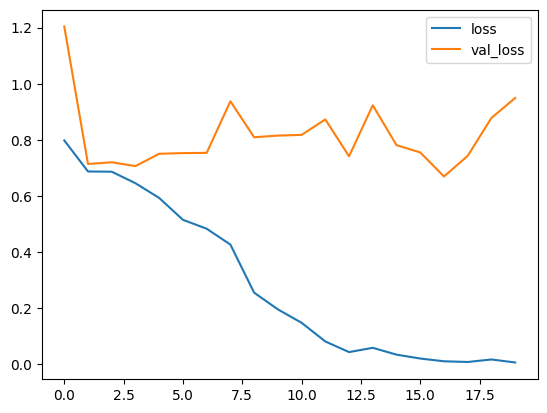

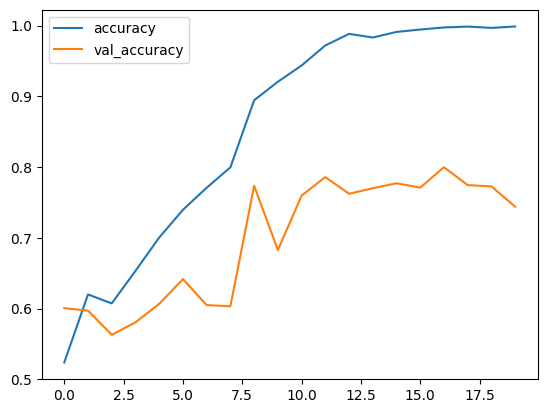

In [14]:
### Model Evaluation
df=pd.DataFrame(tl_model.history.history)
df.to_csv('hist2.csv')
metrics = pd.DataFrame(tl_model.history.history)
metrics[["loss","val_loss"]].plot()
metrics[["accuracy","val_accuracy"]].plot()
tl_model.evaluate(test_image_gen)
predictions = tl_model.predict(test_image_gen, verbose=1)
predictions = predictions.argmax(axis=1)

In [14]:
test_labels = test_image_gen.classes
from tensorflow.keras.models import load_model

final_model = load_model("t3_breast_IRNAdam_NoPreProcess-epoch17.keras")
predictions = final_model.predict(test_image_gen, verbose=1)
predictions = predictions.argmax(axis=1)
test_labels = test_image_gen.classes

143/143 ━━━━━━━━━━━━━━━━━━━━ 19s 55ms/step


Normalized confusion matrix
[[0.58994709 0.41005291]
 [0.09660574 0.90339426]]
              precision    recall  f1-score   support

           0       0.75      0.59      0.66       378
           1       0.82      0.90      0.86       766

    accuracy                           0.80      1144
   macro avg       0.78      0.75      0.76      1144
weighted avg       0.80      0.80      0.79      1144



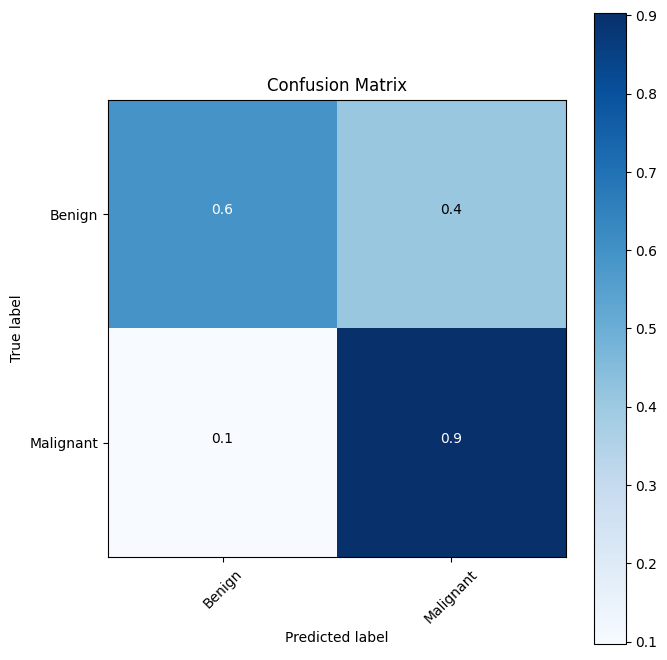

In [15]:
cm = confusion_matrix(test_labels, predictions)
cm
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize=(7,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.1f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
cm_plot_labels = list(test_image_gen.class_indices.keys())

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix', normalize=True)
print(classification_report(test_image_gen.classes, predictions, zero_division=0))


Normalized confusion matrix
[[0.55026455 0.44973545]
 [0.09791123 0.90208877]]


              precision    recall  f1-score   support

           0       0.73      0.55      0.63       378
           1       0.80      0.90      0.85       766

    accuracy                           0.79      1144
   macro avg       0.77      0.73      0.74      1144
weighted avg       0.78      0.79      0.78      1144



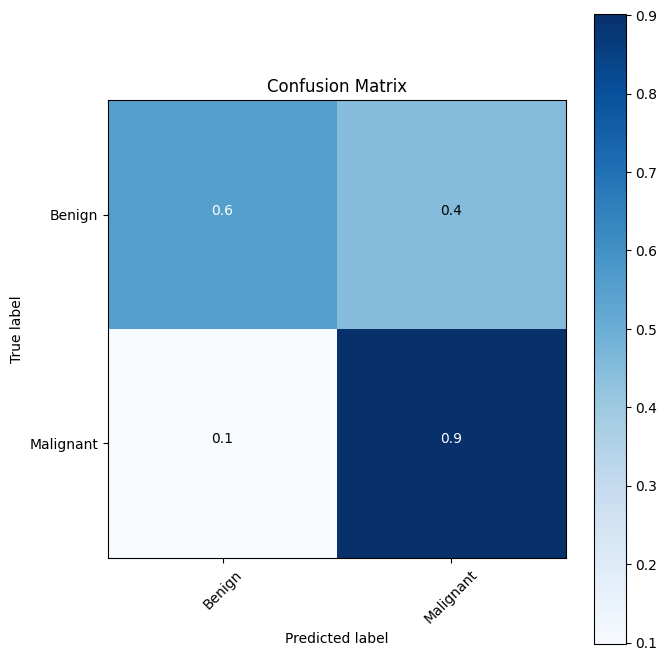

In [9]:
cm = confusion_matrix(test_labels, predictions)
cm
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize=(7,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.1f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
cm_plot_labels = list(test_image_gen.class_indices.keys())

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix', normalize=True)
print(classification_report(test_image_gen.classes, predictions, zero_division=0))


In [9]:
print(classification_report(test_labels, predictions))

              precision    recall  f1-score   support

           0       0.77      0.55      0.65       378
           1       0.81      0.92      0.86       766

    accuracy                           0.80      1144
   macro avg       0.79      0.74      0.75      1144
weighted avg       0.80      0.80      0.79      1144



In [ ]:
              precision    recall  f1-score   support

           0       0.75      0.66      0.70       378
           1       0.84      0.89      0.86       766

    accuracy                           0.81      1144
   macro avg       0.79      0.77      0.78      1144
weighted avg       0.81      0.81      0.81      1144